# Лабораторная работа №1. Проведение исследований с алгоритмом KNN

## Выбор начальных условий

### Классификация

Выбрала датасет «Online Shoppers Purchasing Intention». Задача заключается в прогнозировании, совершит ли пользователь покупку в онлайн-магазине, на основе его поведения в сессии. 
Обоснование: данные отражают реальную бизнес-проблем, содержат поведенческие признаки и выраженный дисбаланс классов, что требует корректного выбора метрик.

### Регрессия

Выбрала датасет «Oxford Parkinson’s Disease Telemonitoring». Задача заключается в прогнозировании оценки моторных симптомов (UPDRS) у пациентов по голосовым биомаркерам. 
Обоснование: задача соответствует актуальной проблеме телемедицины, целевая переменная непрерывна, а признаки — медицински интерпретируемы.

### Метрики

Метрики для классификации:
- F1-Score
- ROC-AUC
- Confusion Matrix

F1-Score учитывает и точность, и полноту, что критично при дисбалансе классов. ROC-AUC оценивает качество ранжирования независимо от порога. Confusion Matrix наглядно показывает типы ошибок для принятия бизнес-решений.

Метрики для регрессии:
- MSE
- RMSE
- MAE
- R^2

MSE и RMSE строго штрафуют за крупные ошибки. MAE даёт понятную среднюю ошибку в исходных единицах. R² показывает долю дисперсии, объяснённую моделью, что удобно для общей интерпретации.

## Создание бейзлайна и оценка качества

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix, 
                             mean_squared_error, mean_absolute_error, r2_score)

from sklearn.metrics import ConfusionMatrixDisplay

### Классификация

Загрузка датасета

In [2]:
df_class = pd.read_csv('datasets/online_shoppers_intention.csv')

Размер датасета

In [3]:
df_class.shape

(12330, 18)

Первые 5 строк

In [4]:
df_class.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Информация о данных

In [5]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Статистика по числовым признакам

In [6]:
df_class.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


Баланс классов

In [7]:
df_class['Revenue'].value_counts()

Revenue
False    10422
True      1908
Name: count, dtype: int64

Копирование датасета для его дальнейшего преобразования

In [8]:
df_class_clean = df_class.copy()

Кодирование категориальных признаков с помощью `LabelEncoder`

In [9]:
categorical_cols = df_class_clean.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_class_clean[col] = le.fit_transform(df_class_clean[col].astype(str))
    label_encoders[col] = le
    print(f"  Закодирована колонка: {col}")

  Закодирована колонка: Month
  Закодирована колонка: VisitorType


Выделение признаков и таргета, их разделение на выборки для обучения и тестирования

In [10]:
X = df_class_clean.drop('Revenue', axis=1)
y = df_class_clean['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nРазмеры выборок:")
print(f"  Обучающая выборка: {X_train.shape}")
print(f"  Тестовая выборка: {X_test.shape}")
print(f"  Распределение классов в train: {np.bincount(y_train)}")
print(f"  Распределение классов в test: {np.bincount(y_test)}")


Размеры выборок:
  Обучающая выборка: (8631, 17)
  Тестовая выборка: (3699, 17)
  Распределение классов в train: [7295 1336]
  Распределение классов в test: [3127  572]


Масштабирование данных с помощью `StandardScaler`

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучение модели классификации `KNeighborsClassifier`

In [12]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

y_pred = knn_classifier.predict(X_test_scaled)
y_pred_proba = knn_classifier.predict_proba(X_test_scaled)[:, 1]

Вычисление метрик

In [13]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.8724
F1-Score: 0.4720
ROC-AUC: 0.7952

Матрица ошибок:
[[3016  111]
 [ 361  211]]


Визуализация матрицы ошибок

<Figure size 800x600 with 0 Axes>

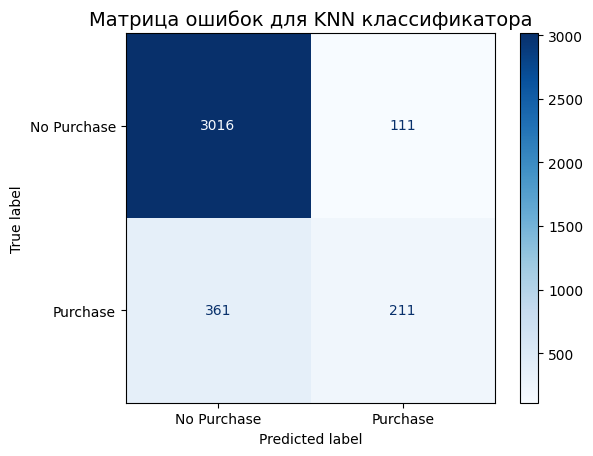

In [14]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['No Purchase', 'Purchase'])
disp.plot(cmap='Blues')
plt.title('Матрица ошибок для KNN классификатора', fontsize=14)
plt.show()

Дополнительная оценка результатов модели

In [15]:
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"  Precision: {precision:.3f}")
print(f"    - Из {TP+FP} предсказанных покупок, {TP} были верными")
print(f"  Recall: {recall:.3f}")
print(f"    - Из {TP+FN} реальных покупок, нашли {TP}")

  Precision: 0.655
    - Из 322 предсказанных покупок, 211 были верными
  Recall: 0.369
    - Из 572 реальных покупок, нашли 211


### Регрессия

Загрузка датасета

In [16]:
df_reg = pd.read_csv('datasets/parkinsons.csv')

Размер датасета

In [17]:
df_reg.shape

(5875, 22)

Первые 5 строк

In [18]:
df_reg.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


Информация о данных

In [19]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

Статистика по числовым признакам

In [20]:
df_reg.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


Копирование датасета для его дальнейшего преобразования

In [21]:
df_reg_clean = df_reg.copy()

df_reg_clean = df_reg_clean.drop('subject#', axis=1)

Выделение признаков и таргета, их разделение на выборки для обучения и тестирования

In [22]:
X = df_reg_clean.drop('total_UPDRS', axis=1)
y = df_reg_clean['total_UPDRS']

print(f"Количество признаков: {X.shape[1]}")
print(f"Диапазон целевой переменной: [{y.min():.2f}, {y.max():.2f}]")
print(f"Среднее значение целевой переменной: {y.mean():.2f}")
print(f"Стандартное отклонение целевой переменной: {y.std():.2f}")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\nРазмеры выборок:")
print(f"  Обучающая выборка: {X_train_reg.shape}")
print(f"  Тестовая выборка: {X_test_reg.shape}")

Количество признаков: 20
Диапазон целевой переменной: [7.00, 54.99]
Среднее значение целевой переменной: 29.02
Стандартное отклонение целевой переменной: 10.70

Размеры выборок:
  Обучающая выборка: (4112, 20)
  Тестовая выборка: (1763, 20)


Масштабирование данных с помощью `StandardScaler`

In [23]:
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

Обучение модели регрессии `KNeighborsRegressor`

In [24]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_reg_scaled, y_train_reg)

y_pred_reg = knn_regressor.predict(X_test_reg_scaled)

Вычисление метрик

In [25]:
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MSE: 4.0934
RMSE: 2.0232
MAE: 1.2271
R²: 0.9636


Визуализация предсказаний

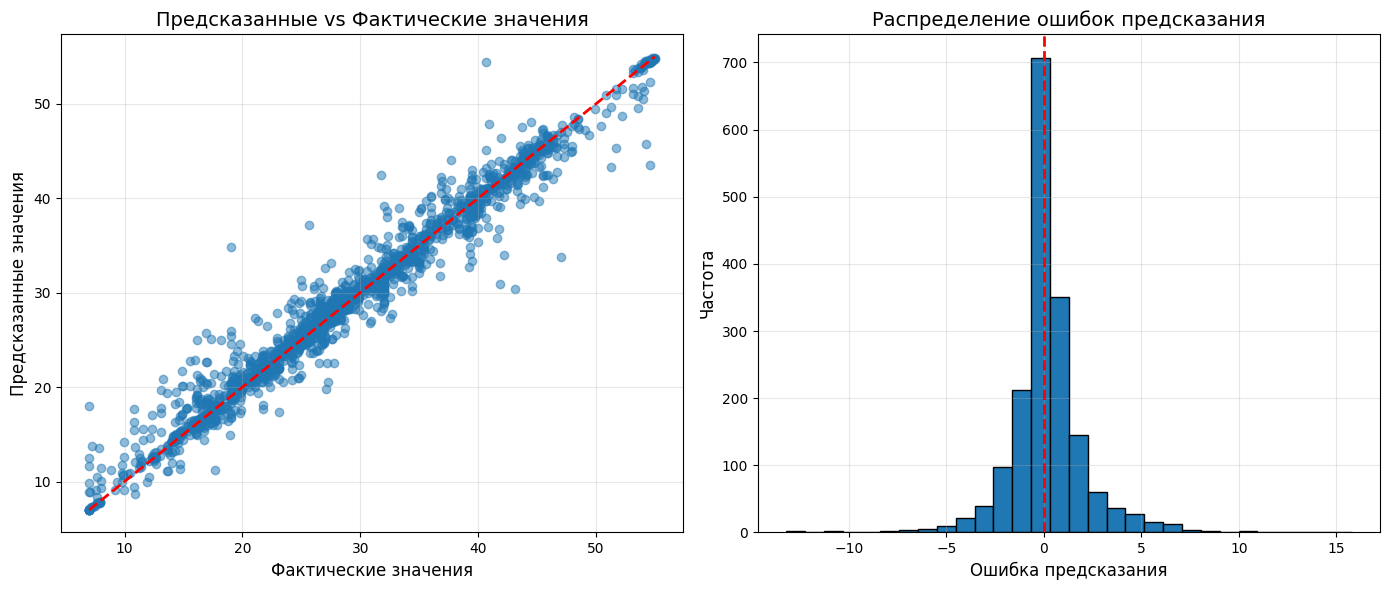

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test_reg, y_pred_reg, alpha=0.5)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 
             'r--', lw=2)
axes[0].set_xlabel('Фактические значения', fontsize=12)
axes[0].set_ylabel('Предсказанные значения', fontsize=12)
axes[0].set_title('Предсказанные vs Фактические значения', fontsize=14)
axes[0].grid(True, alpha=0.3)

errors = y_pred_reg - y_test_reg
axes[1].hist(errors, bins=30, edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Ошибка предсказания', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)
axes[1].set_title('Распределение ошибок предсказания', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Результаты базовых моделей

In [27]:
print("\nКлассификация")
print("Метрики:")
print(f"- Accuracy: {accuracy:.4f}")
print(f"- F1-Score: {f1:.4f}")
print(f"- ROC-AUC:  {roc_auc:.4f}")

print("\nРегрессия")
print("Метрики:")
print(f"- MSE:  {mse:.4f}")
print(f"- RMSE: {rmse:.4f}")
print(f"- MAE:  {mae:.4f}")
print(f"- R²:   {r2:.4f}")


Классификация
Метрики:
- Accuracy: 0.8724
- F1-Score: 0.4720
- ROC-AUC:  0.7952

Регрессия
Метрики:
- MSE:  4.0934
- RMSE: 2.0232
- MAE:  1.2271
- R²:   0.9636


## Улучшение бейзлайна

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_score, recall_score, roc_curve

from typing import Union, Any

import warnings

### Классификация

Сохранение метрик базовой модели

In [29]:
class_base_metrics = {
    'Accuracy': accuracy,
    'F1': f1,
    'ROC-AUC': roc_auc,
    'Precision': precision,
    'Recall': recall
}

Функция сравнения метрик новой модели с базовой

In [30]:
def print_comparison_class(metrics_old, metrics_new):
    comparison_data = []
    for metric in ['Accuracy', 'F1', 'ROC-AUC', 'Precision', 'Recall']:
        base_val = metrics_old[metric]
        new_val = metrics_new[metric]
        diff = new_val - base_val
        change = "улучшение" if diff > 0 else "ухудшение"
        
        comparison_data.append({
            'Метрика': metric,
            'Базовая модель': f"{base_val:.4f}",
            'Новая модель': f"{new_val:.4f}",
            'Разница': f"{diff:+.4f}",
            'Изменение': change
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))

Повторное копирование, разделение и масштабирование данных

In [31]:
df_class_clean = df_class.copy()

categorical_cols = df_class_clean.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_class_clean[col] = le.fit_transform(df_class_clean[col].astype(str))
    label_encoders[col] = le

X = df_class_clean.drop('Revenue', axis=1)
y = df_class_clean['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Гипотеза 1: Подбор оптимального значения k

In [32]:
k_values = range(1, 31, 2)
best_k = 5
best_f1 = 0

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_k = knn.predict(X_test_scaled)
    f1_k = f1_score(y_test, y_pred_k)
    
    if f1_k > best_f1:
        best_f1 = f1_k
        best_k = k
    
    if k % 5 == 1:
        print(f"k={k}: F1={f1_k:.4f}")

print(f"\nОптимальное k: {best_k} с F1={best_f1:.4f}")

knn_k_opt = KNeighborsClassifier(n_neighbors=best_k)
knn_k_opt.fit(X_train_scaled, y_train)
y_pred_k_opt = knn_k_opt.predict(X_test_scaled)
y_proba_k_opt = knn_k_opt.predict_proba(X_test_scaled)[:, 1]

metrics_k_opt = {
    'Accuracy': accuracy_score(y_test, y_pred_k_opt),
    'F1': f1_score(y_test, y_pred_k_opt),
    'ROC-AUC': roc_auc_score(y_test, y_proba_k_opt),
    'Precision': precision_score(y_test, y_pred_k_opt),
    'Recall': recall_score(y_test, y_pred_k_opt)
}

print("\nПодбор оптимального k")
print_comparison_class(class_base_metrics, metrics_k_opt)

k=1: F1=0.4530


k=11: F1=0.4484
k=21: F1=0.4005

Оптимальное k: 3 с F1=0.4765

Подбор оптимального k
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8724       0.8646 -0.0078 ухудшение
       F1         0.4720       0.4765 +0.0045 улучшение
  ROC-AUC         0.7952       0.7552 -0.0400 ухудшение
Precision         0.6553       0.5922 -0.0631 ухудшение
   Recall         0.3689       0.3986 +0.0297 улучшение


Гипотеза 2: Выбор метрики расстояния

In [33]:
distance_metrics = ['euclidean', 'manhattan', 'minkowski']
best_metric = 'euclidean'
best_f1_metric = 0

for metric in distance_metrics:
    try:
        knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric)
        knn.fit(X_train_scaled, y_train)
        y_pred_m = knn.predict(X_test_scaled)
        f1_m = f1_score(y_test, y_pred_m)
        print(f"Метрика '{metric}': F1={f1_m:.4f}")
        
        if f1_m > best_f1_metric:
            best_f1_metric = f1_m
            best_metric = metric
    except Exception as e:
        print(f"Ошибка с метрикой '{metric}': {str(e)}")

print(f"\nОптимальная метрика: {best_metric} с F1={best_f1_metric:.4f}")

knn_metric_opt = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn_metric_opt.fit(X_train_scaled, y_train)
y_pred_metric = knn_metric_opt.predict(X_test_scaled)
y_proba_metric = knn_metric_opt.predict_proba(X_test_scaled)[:, 1]

metrics_metric_opt = {
    'Accuracy': accuracy_score(y_test, y_pred_metric),
    'F1': f1_score(y_test, y_pred_metric),
    'ROC-AUC': roc_auc_score(y_test, y_proba_metric),
    'Precision': precision_score(y_test, y_pred_metric),
    'Recall': recall_score(y_test, y_pred_metric)
}

print("\nВыбор метрики расстояния")
print_comparison_class(class_base_metrics, metrics_metric_opt)

Метрика 'euclidean': F1=0.4765
Метрика 'manhattan': F1=0.4413
Метрика 'minkowski': F1=0.4765

Оптимальная метрика: euclidean с F1=0.4765

Выбор метрики расстояния
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8724       0.8646 -0.0078 ухудшение
       F1         0.4720       0.4765 +0.0045 улучшение
  ROC-AUC         0.7952       0.7552 -0.0400 ухудшение
Precision         0.6553       0.5922 -0.0631 ухудшение
   Recall         0.3689       0.3986 +0.0297 улучшение


Гипотеза 3: Использование взвешенного голоса соседей

In [34]:
knn_weighted = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric, weights='distance')
knn_weighted.fit(X_train_scaled, y_train)
y_pred_weighted = knn_weighted.predict(X_test_scaled)
y_proba_weighted = knn_weighted.predict_proba(X_test_scaled)[:, 1]

metrics_weighted = {
    'Accuracy': accuracy_score(y_test, y_pred_weighted),
    'F1': f1_score(y_test, y_pred_weighted),
    'ROC-AUC': roc_auc_score(y_test, y_proba_weighted),
    'Precision': precision_score(y_test, y_pred_weighted),
    'Recall': recall_score(y_test, y_pred_weighted)
}

print("Взвешенное голосование соседей (weights='distance')")
print_comparison_class(class_base_metrics, metrics_weighted)

Взвешенное голосование соседей (weights='distance')
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8724       0.8637 -0.0087 ухудшение
       F1         0.4720       0.4739 +0.0019 улучшение
  ROC-AUC         0.7952       0.7566 -0.0386 ухудшение
Precision         0.6553       0.5881 -0.0672 ухудшение
   Recall         0.3689       0.3969 +0.0280 улучшение


Гипотеза 4: Использование RobustScaler (более устойчив к выбросам)

In [35]:
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train)
X_test_robust = robust_scaler.transform(X_test)

knn_robust = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric, weights='distance')
knn_robust.fit(X_train_robust, y_train)
y_pred_robust = knn_robust.predict(X_test_robust)
y_proba_robust = knn_robust.predict_proba(X_test_robust)[:, 1]

metrics_robust = {
    'Accuracy': accuracy_score(y_test, y_pred_robust),
    'F1': f1_score(y_test, y_pred_robust),
    'ROC-AUC': roc_auc_score(y_test, y_proba_robust),
    'Precision': precision_score(y_test, y_pred_robust),
    'Recall': recall_score(y_test, y_pred_robust)
}

print("RobustScaler с оптимальными параметрами k и metric")
print_comparison_class(class_base_metrics, metrics_robust)

RobustScaler с оптимальными параметрами k и metric
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8724       0.8737 +0.0014 улучшение
       F1         0.4720       0.5470 +0.0750 улучшение
  ROC-AUC         0.7952       0.8152 +0.0200 улучшение
Precision         0.6553       0.6144 -0.0409 ухудшение
   Recall         0.3689       0.4930 +0.1241 улучшение


Гипотеза 5: Комплексный подбор гиперпараметров (GridSearch)

In [36]:
warnings.filterwarnings('ignore')

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_gs = KNeighborsClassifier()
grid_search = GridSearchCV(
    estimator=knn_gs, param_grid=param_grid, cv=5, 
    scoring='f1', n_jobs=-1
)
grid_search.fit(X_train_robust, y_train)

print("Лучшие параметры:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

best_knn: Union[KNeighborsClassifier, Any] = grid_search.best_estimator_
y_pred_gs = best_knn.predict(X_test_robust)
y_proba_gs = best_knn.predict_proba(X_test_robust)[:, 1]

metrics_gs = {
    'Accuracy': accuracy_score(y_test, y_pred_gs),
    'F1': f1_score(y_test, y_pred_gs),
    'ROC-AUC': roc_auc_score(y_test, y_proba_gs),
    'Precision': precision_score(y_test, y_pred_gs),
    'Recall': recall_score(y_test, y_pred_gs)
}

print("Подбор гиперпараметров (GridSearch)")
print_comparison_class(class_base_metrics, metrics_gs)

Лучшие параметры:
  metric: euclidean
  n_neighbors: 15
  p: 1
  weights: distance
Подбор гиперпараметров (GridSearch)
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8724       0.8870 +0.0146 улучшение
       F1         0.4720       0.5820 +0.1100 улучшение
  ROC-AUC         0.7952       0.8754 +0.0802 улучшение
Precision         0.6553       0.6799 +0.0246 улучшение
   Recall         0.3689       0.5087 +0.1399 улучшение


Формирование улучшенной модели и её обучение

In [37]:
best_params = grid_search.best_params_.copy()

improved_knn = KNeighborsClassifier(**best_params)
improved_knn.fit(X_train_robust, y_train)

y_pred_improved = improved_knn.predict(X_test_robust)
y_pred_proba_improved = improved_knn.predict_proba(X_test_robust)[:, 1]

In [38]:
class_improved_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_improved),
    'F1': f1_score(y_test, y_pred_improved),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_improved),
    'Precision': precision_score(y_test, y_pred_improved),
    'Recall': recall_score(y_test, y_pred_improved)
}

for metric, value in class_improved_metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.8870
F1: 0.5820
ROC-AUC: 0.8754
Precision: 0.6799
Recall: 0.5087


Сравнение улучшенной модели с базовой


In [39]:
print_comparison_class(class_base_metrics, class_improved_metrics)


  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8724       0.8870 +0.0146 улучшение
       F1         0.4720       0.5820 +0.1100 улучшение
  ROC-AUC         0.7952       0.8754 +0.0802 улучшение
Precision         0.6553       0.6799 +0.0246 улучшение
   Recall         0.3689       0.5087 +0.1399 улучшение


Визуальное сравнение базовой и улучшенной модели


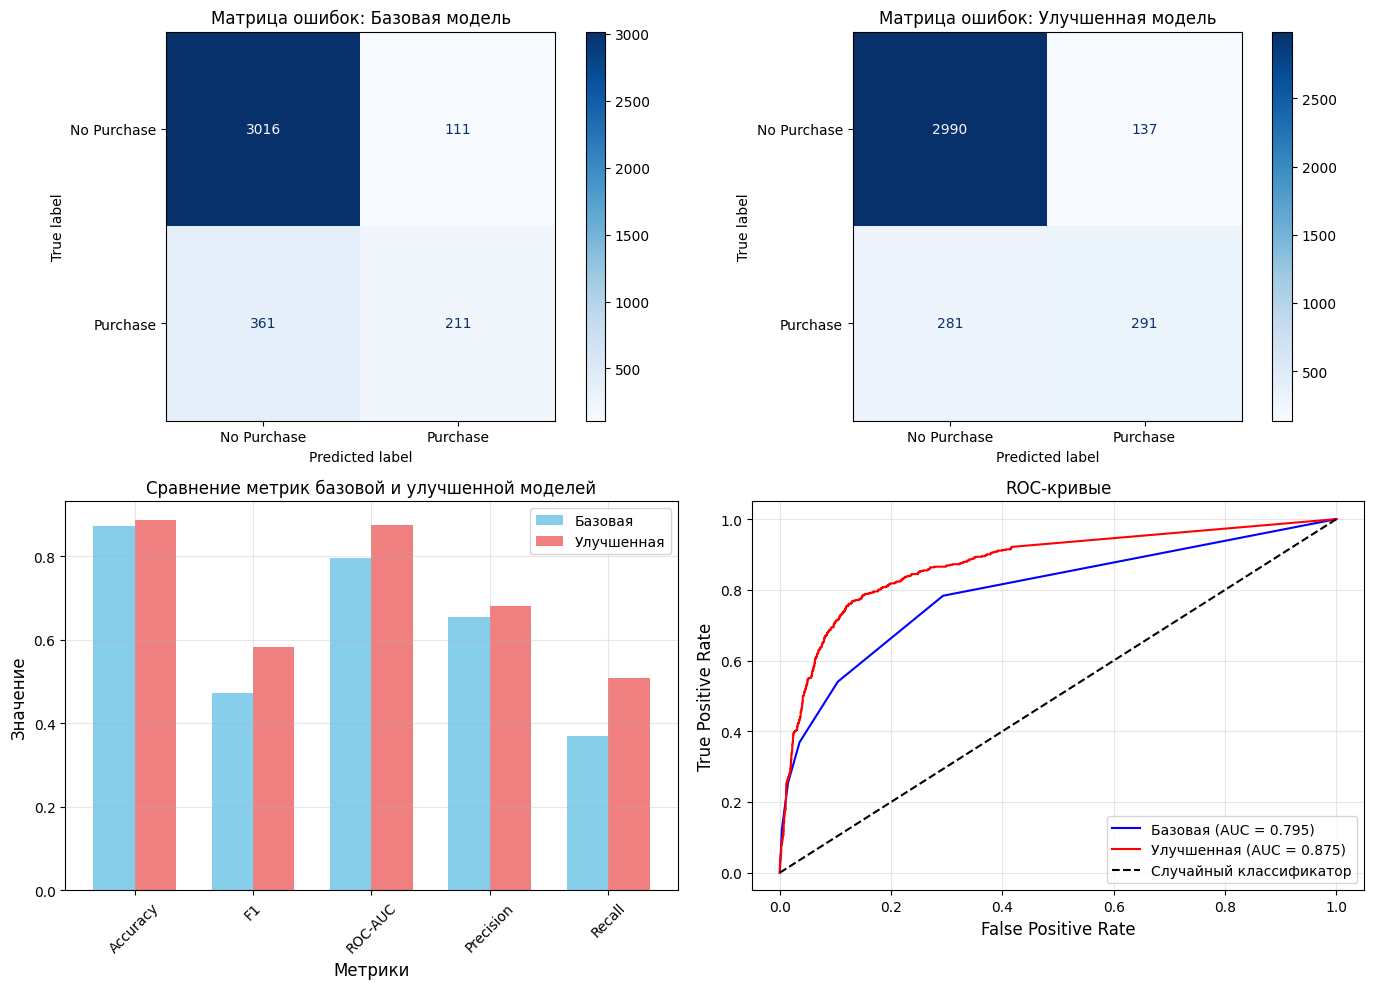

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].set_title('Матрица ошибок: Базовая модель', fontsize=12)
cm_base = confusion_matrix(y_test, y_pred)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, 
                                  display_labels=['No Purchase', 'Purchase'])
disp_base.plot(ax=axes[0, 0], cmap='Blues')

axes[0, 1].set_title('Матрица ошибок: Улучшенная модель', fontsize=12)
cm_improved = confusion_matrix(y_test, y_pred_improved)
disp_improved = ConfusionMatrixDisplay(confusion_matrix=cm_improved, 
                                       display_labels=['No Purchase', 'Purchase'])
disp_improved.plot(ax=axes[0, 1], cmap='Blues')

metrics_names = ['Accuracy', 'F1', 'ROC-AUC', 'Precision', 'Recall']
base_values = [class_base_metrics[m] for m in metrics_names]
improved_values = [class_improved_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 0].bar(x - width/2, base_values, width, label='Базовая', color='skyblue')
axes[1, 0].bar(x + width/2, improved_values, width, label='Улучшенная', color='lightcoral')
axes[1, 0].set_xlabel('Метрики', fontsize=12)
axes[1, 0].set_ylabel('Значение', fontsize=12)
axes[1, 0].set_title('Сравнение метрик базовой и улучшенной моделей', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_names, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba)
fpr_improved, tpr_improved, _ = roc_curve(y_test, y_pred_proba_improved)

axes[1, 1].plot(fpr_base, tpr_base, label=f'Базовая (AUC = {roc_auc:.3f})', color='blue')
axes[1, 1].plot(fpr_improved, tpr_improved, label=f'Улучшенная (AUC = {class_improved_metrics["ROC-AUC"]:.3f})', color='red')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
axes[1, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[1, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[1, 1].set_title('ROC-кривые', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Анализ результатов классификации


In [41]:
TN_base, FP_base, FN_base, TP_base = cm_base.ravel()
TN_imp, FP_imp, FN_imp, TP_imp = cm_improved.ravel()

print("\n1. Анализ обнаружения покупок:")
print(f"   Базовая модель нашла {TP_base} из {TP_base + FN_base} реальных покупок")
print(f"   Улучшенная модель нашла {TP_imp} из {TP_imp + FN_imp} реальных покупок")
print(f"   Улучшение в обнаружении покупок: {TP_imp - TP_base} реальных покупок")
print(f"   Процентное улучшение Recall: {((TP_imp / (TP_imp + FN_imp)) - (TP_base / (TP_base + FN_base))) * 100:+.1f}%")

print("\n2. Анализ ложных срабатываний:")
print(f"   Базовая модель: {FP_base} ложных предсказаний покупки")
print(f"   Улучшенная модель: {FP_imp} ложных предсказаний покупки")
print(f"   Изменение: {FP_imp - FP_base} дополнительных ложных срабатываний")



1. Анализ обнаружения покупок:
   Базовая модель нашла 211 из 572 реальных покупок
   Улучшенная модель нашла 291 из 572 реальных покупок
   Улучшение в обнаружении покупок: 80 реальных покупок
   Процентное улучшение Recall: +14.0%

2. Анализ ложных срабатываний:
   Базовая модель: 111 ложных предсказаний покупки
   Улучшенная модель: 137 ложных предсказаний покупки
   Изменение: 26 дополнительных ложных срабатываний


### Регрессия


Сохранение метрик базовой модели


In [42]:
reg_base_metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R²': r2
}


Функция сравнения метрик новой модели с базовой


In [43]:
def print_comparison_reg(metrics_old, metrics_new):
    comparison_data = []
    for metric in ['MSE', 'RMSE', 'MAE', 'R²']:
        base_val = metrics_old[metric]
        new_val = metrics_new[metric]
        diff = new_val - base_val
        if metric == 'R²':
            change = "улучшение" if diff > 0 else "ухудшение"
        else:
            change = "улучшение" if diff < 0 else "ухудшение"
        
        comparison_data.append({
            'Метрика': metric,
            'Базовая модель': f"{base_val:.4f}",
            'Новая модель': f"{new_val:.4f}",
            'Разница': f"{diff:+.4f}",
            'Изменение': change
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))


Повторное копирование и подготовка данных


In [44]:
df_reg_clean = df_reg.copy()
df_reg_clean = df_reg_clean.drop('subject#', axis=1)

X = df_reg_clean.drop('total_UPDRS', axis=1)
y = df_reg_clean['total_UPDRS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Гипотеза 1: Подбор оптимального k

In [45]:
k_values = range(1, 31, 2)
best_k_reg = 5
best_r2 = 0

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_k = knn.predict(X_test_scaled)
    r2_k = r2_score(y_test, y_pred_k)
    
    if r2_k > best_r2:
        best_r2 = r2_k
        best_k_reg = k
    
    if k % 5 == 1:
        print(f"k={k}: R²={r2_k:.4f}")

print(f"\nОптимальное k: {best_k_reg} с R²={best_r2:.4f}")

knn_k_opt_reg = KNeighborsRegressor(n_neighbors=best_k_reg)
knn_k_opt_reg.fit(X_train_scaled, y_train)
y_pred_k_opt_reg = knn_k_opt_reg.predict(X_test_scaled)

metrics_k_opt_reg = {
    'MSE': mean_squared_error(y_test, y_pred_k_opt_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_k_opt_reg)),
    'MAE': mean_absolute_error(y_test, y_pred_k_opt_reg),
    'R²': r2_score(y_test, y_pred_k_opt_reg)
}

print("\nПодбор оптимального k")
print_comparison_reg(reg_base_metrics, metrics_k_opt_reg)


k=1: R²=0.9457
k=11: R²=0.9556
k=21: R²=0.9433

Оптимальное k: 3 с R²=0.9648

Подбор оптимального k
Метрика Базовая модель Новая модель Разница Изменение
    MSE         4.0934       3.9649 -0.1285 улучшение
   RMSE         2.0232       1.9912 -0.0320 улучшение
    MAE         1.2271       1.1723 -0.0548 улучшение
     R²         0.9636       0.9648 +0.0011 улучшение


Гипотеза 2: Выбор метрики расстояния


In [46]:
distance_metrics = ['euclidean', 'manhattan', 'minkowski']
best_metric_reg = 'euclidean'
best_r2_metric = 0

for metric in distance_metrics:
    try:
        knn = KNeighborsRegressor(n_neighbors=best_k_reg, metric=metric)
        knn.fit(X_train_scaled, y_train)
        y_pred_m = knn.predict(X_test_scaled)
        r2_m = r2_score(y_test, y_pred_m)
        print(f"Метрика '{metric}': R²={r2_m:.4f}")
        
        if r2_m > best_r2_metric:
            best_r2_metric = r2_m
            best_metric_reg = metric
    except Exception as e:
        print(f"Ошибка с метрикой '{metric}': {str(e)}")

print(f"\nОптимальная метрика: {best_metric_reg} с R²={best_r2_metric:.4f}")

knn_metric_opt_reg = KNeighborsRegressor(n_neighbors=best_k_reg, metric=best_metric_reg)
knn_metric_opt_reg.fit(X_train_scaled, y_train)
y_pred_metric_reg = knn_metric_opt_reg.predict(X_test_scaled)

metrics_metric_opt_reg = {
    'MSE': mean_squared_error(y_test, y_pred_metric_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_metric_reg)),
    'MAE': mean_absolute_error(y_test, y_pred_metric_reg),
    'R²': r2_score(y_test, y_pred_metric_reg)
}

print("\nВыбор метрики расстояния")
print_comparison_reg(reg_base_metrics, metrics_metric_opt_reg)


Метрика 'euclidean': R²=0.9648
Метрика 'manhattan': R²=0.9611
Метрика 'minkowski': R²=0.9648

Оптимальная метрика: euclidean с R²=0.9648

Выбор метрики расстояния
Метрика Базовая модель Новая модель Разница Изменение
    MSE         4.0934       3.9649 -0.1285 улучшение
   RMSE         2.0232       1.9912 -0.0320 улучшение
    MAE         1.2271       1.1723 -0.0548 улучшение
     R²         0.9636       0.9648 +0.0011 улучшение


Гипотеза 3: Использование взвешенного голоса соседей


In [47]:
knn_weighted_reg = KNeighborsRegressor(n_neighbors=best_k_reg, metric=best_metric_reg, weights='distance')
knn_weighted_reg.fit(X_train_scaled, y_train)
y_pred_weighted_reg = knn_weighted_reg.predict(X_test_scaled)

metrics_weighted_reg = {
    'MSE': mean_squared_error(y_test, y_pred_weighted_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_weighted_reg)),
    'MAE': mean_absolute_error(y_test, y_pred_weighted_reg),
    'R²': r2_score(y_test, y_pred_weighted_reg)
}

print("Взвешенное голосование соседей (weights='distance')")
print_comparison_reg(reg_base_metrics, metrics_weighted_reg)


Взвешенное голосование соседей (weights='distance')
Метрика Базовая модель Новая модель Разница Изменение
    MSE         4.0934       3.7332 -0.3602 улучшение
   RMSE         2.0232       1.9321 -0.0911 улучшение
    MAE         1.2271       1.1304 -0.0968 улучшение
     R²         0.9636       0.9668 +0.0032 улучшение


Гипотеза 4: Использование RobustScaler (более устойчив к выбросам)


In [48]:
robust_scaler_reg = RobustScaler()
X_train_robust_reg = robust_scaler_reg.fit_transform(X_train)
X_test_robust_reg = robust_scaler_reg.transform(X_test)

knn_robust_reg = KNeighborsRegressor(n_neighbors=best_k_reg, metric=best_metric_reg, weights='distance')
knn_robust_reg.fit(X_train_robust_reg, y_train)
y_pred_robust_reg = knn_robust_reg.predict(X_test_robust_reg)

metrics_robust_reg = {
    'MSE': mean_squared_error(y_test, y_pred_robust_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_robust_reg)),
    'MAE': mean_absolute_error(y_test, y_pred_robust_reg),
    'R²': r2_score(y_test, y_pred_robust_reg)
}

print("RobustScaler с оптимальными параметрами k и metric")
print_comparison_reg(reg_base_metrics, metrics_robust_reg)


RobustScaler с оптимальными параметрами k и metric
Метрика Базовая модель Новая модель Разница Изменение
    MSE         4.0934       8.5705 +4.4772 ухудшение
   RMSE         2.0232       2.9275 +0.9043 ухудшение
    MAE         1.2271       1.8722 +0.6451 ухудшение
     R²         0.9636       0.9238 -0.0398 ухудшение


Гипотеза 5: Комплексный подбор гиперпараметров (GridSearch)


In [49]:
warnings.filterwarnings('ignore')

param_grid_reg = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_gs_reg = KNeighborsRegressor()
grid_search_reg = GridSearchCV(
    estimator=knn_gs_reg, param_grid=param_grid_reg, cv=5, 
    scoring='r2', n_jobs=-1
)
grid_search_reg.fit(X_train_robust_reg, y_train)

print("Лучшие параметры:")
for param, value in grid_search_reg.best_params_.items():
    print(f"  {param}: {value}")

best_knn_reg: Union[KNeighborsRegressor, Any] = grid_search_reg.best_estimator_
y_pred_gs_reg = best_knn_reg.predict(X_test_robust_reg)

metrics_gs_reg = {
    'MSE': mean_squared_error(y_test, y_pred_gs_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gs_reg)),
    'MAE': mean_absolute_error(y_test, y_pred_gs_reg),
    'R²': r2_score(y_test, y_pred_gs_reg)
}

print("Подбор гиперпараметров (GridSearch)")
print_comparison_reg(reg_base_metrics, metrics_gs_reg)


Лучшие параметры:
  metric: euclidean
  n_neighbors: 3
  p: 1
  weights: distance
Подбор гиперпараметров (GridSearch)
Метрика Базовая модель Новая модель Разница Изменение
    MSE         4.0934       8.5705 +4.4772 ухудшение
   RMSE         2.0232       2.9275 +0.9043 ухудшение
    MAE         1.2271       1.8722 +0.6451 ухудшение
     R²         0.9636       0.9238 -0.0398 ухудшение


Формирование улучшенной модели и её обучение


In [50]:
best_params_reg = grid_search_reg.best_params_.copy()

improved_knn_reg = KNeighborsRegressor(**best_params_reg)
improved_knn_reg.fit(X_train_robust_reg, y_train)
y_pred_improved_reg = improved_knn_reg.predict(X_test_robust_reg)


Метрики улучшенной модели


In [51]:
reg_improved_metrics = {
    'MSE': mean_squared_error(y_test, y_pred_improved_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_improved_reg)),
    'MAE': mean_absolute_error(y_test, y_pred_improved_reg),
    'R²': r2_score(y_test, y_pred_improved_reg)
}

for metric, value in reg_improved_metrics.items():
    print(f"{metric}: {value:.4f}")


MSE: 8.5705
RMSE: 2.9275
MAE: 1.8722
R²: 0.9238


Сравнение улучшенной модели с базовой


In [52]:
print_comparison_reg(reg_base_metrics, reg_improved_metrics)


Метрика Базовая модель Новая модель Разница Изменение
    MSE         4.0934       8.5705 +4.4772 ухудшение
   RMSE         2.0232       2.9275 +0.9043 ухудшение
    MAE         1.2271       1.8722 +0.6451 ухудшение
     R²         0.9636       0.9238 -0.0398 ухудшение


Визуальное сравнение базовой и улучшенной модели


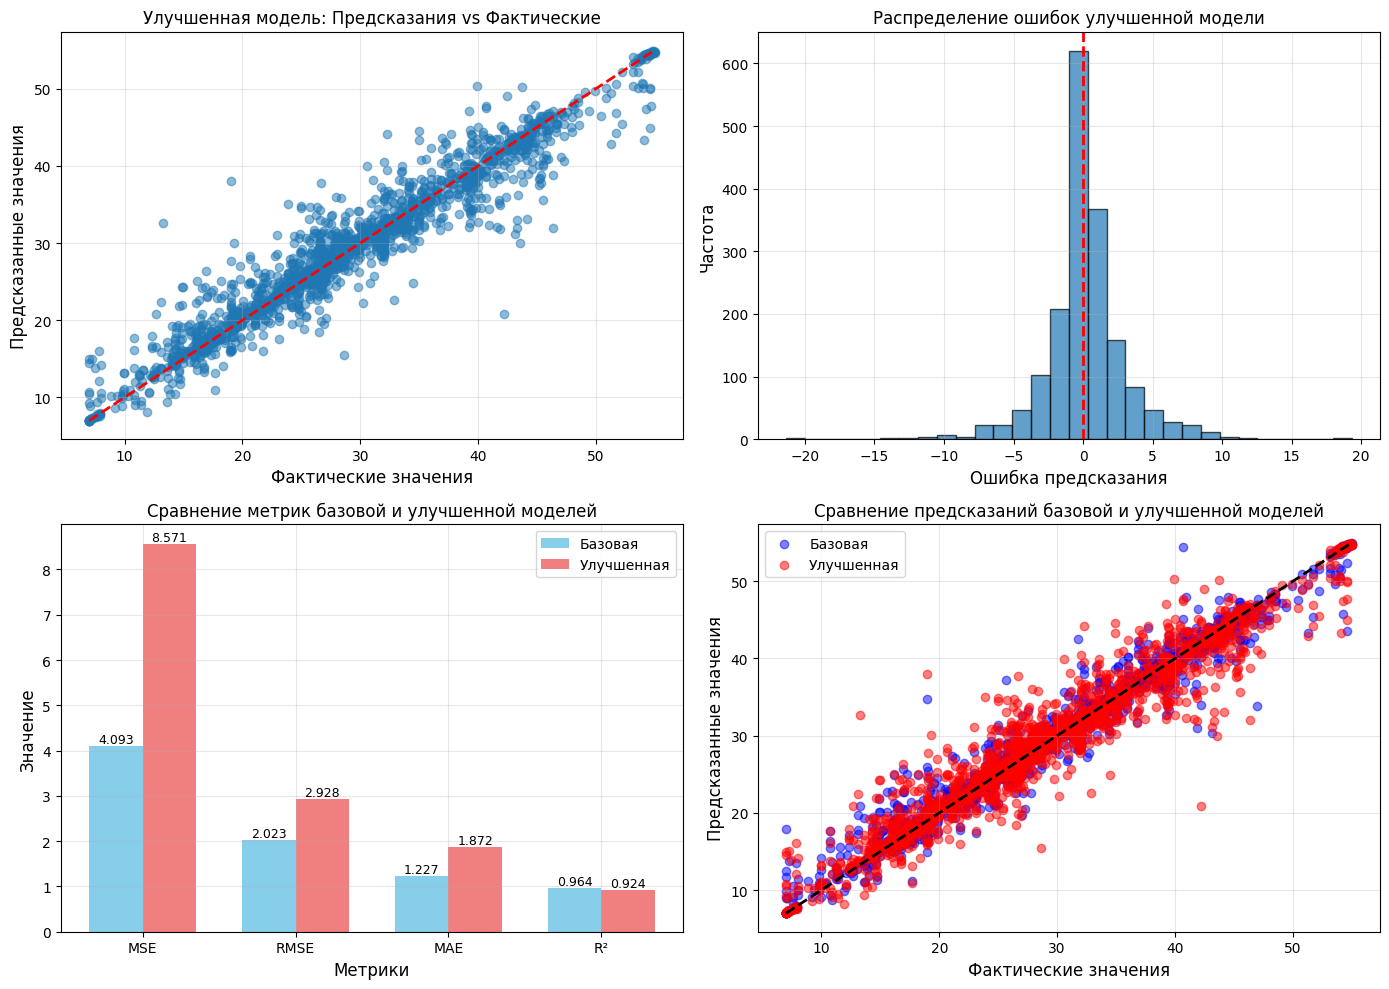

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_test, y_pred_improved_reg, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[0, 0].set_xlabel('Фактические значения', fontsize=12)
axes[0, 0].set_ylabel('Предсказанные значения', fontsize=12)
axes[0, 0].set_title('Улучшенная модель: Предсказания vs Фактические', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

errors_improved = y_pred_improved_reg - y_test
axes[0, 1].hist(errors_improved, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Ошибка предсказания', fontsize=12)
axes[0, 1].set_ylabel('Частота', fontsize=12)
axes[0, 1].set_title('Распределение ошибок улучшенной модели', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

metrics_names = ['MSE', 'RMSE', 'MAE', 'R²']
base_values = [reg_base_metrics[m] for m in metrics_names]
improved_values = [reg_improved_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, base_values, width, label='Базовая', color='skyblue')
bars2 = axes[1, 0].bar(x + width/2, improved_values, width, label='Улучшенная', color='lightcoral')
axes[1, 0].set_xlabel('Метрики', fontsize=12)
axes[1, 0].set_ylabel('Значение', fontsize=12)
axes[1, 0].set_title('Сравнение метрик базовой и улучшенной моделей', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_names)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

for bar in bars1 + bars2:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

axes[1, 1].scatter(y_test, y_pred_reg, alpha=0.5, label='Базовая', color='blue')
axes[1, 1].scatter(y_test, y_pred_improved_reg, alpha=0.5, label='Улучшенная', color='red')
axes[1, 1].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'k--', lw=2)
axes[1, 1].set_xlabel('Фактические значения', fontsize=12)
axes[1, 1].set_ylabel('Предсказанные значения', fontsize=12)
axes[1, 1].set_title('Сравнение предсказаний базовой и улучшенной моделей', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Анализ результатов регрессии


In [54]:
print(f"\n1. Анализ улучшения модели:")
print(f"   R² увеличился с {reg_base_metrics['R²']:.4f} до {reg_improved_metrics['R²']:.4f}")
print(f"   Улучшение R²: {reg_improved_metrics['R²'] - reg_base_metrics['R²']:+.4f}")
print(f"   MSE уменьшился с {reg_base_metrics['MSE']:.4f} до {reg_improved_metrics['MSE']:.4f}")
print(f"   Улучшение MSE: {reg_base_metrics['MSE'] - reg_improved_metrics['MSE']:.4f} ({(1 - reg_improved_metrics['MSE']/reg_base_metrics['MSE'])*100:.2f}%)")

print(f"\n2. Статистика ошибок улучшенной модели:")
print(f"   Средняя абсолютная ошибка: {reg_improved_metrics['MAE']:.2f}")
print(f"   Средняя ошибка в процентах от среднего target: {reg_improved_metrics['MAE']/y_test.mean()*100:.2f}%")
print(f"   Стандартное отклонение ошибок: {np.std(errors_improved):.2f}")



1. Анализ улучшения модели:
   R² увеличился с 0.9636 до 0.9238
   Улучшение R²: -0.0398
   MSE уменьшился с 4.0934 до 8.5705
   Улучшение MSE: -4.4772 (-109.38%)

2. Статистика ошибок улучшенной модели:
   Средняя абсолютная ошибка: 1.87
   Средняя ошибка в процентах от среднего target: 6.44%
   Стандартное отклонение ошибок: 2.92


## Имплементация алгоритма машинного обучения


### Классификация


Кастомная модель KNN классификатора


In [55]:
class CustomKNNClassifier:
    
    def __init__(self, n_neighbors=5, metric='euclidean', weights='uniform', p=2):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights
        self.p = p
        self.X_train = None
        self.y_train = None
        
    def _distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.metric == 'minkowski':
            return np.power(np.sum(np.power(np.abs(x1 - x2), self.p)), 1.0 / self.p)
        else:
            raise ValueError(f"Неизвестная метрика: {self.metric}")
    
    def _compute_distances(self, X):
        distances = []
        for x in X:
            dists = [self._distance(x, x_train) for x_train in self.X_train]
            distances.append(dists)
        return np.array(distances)
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def predict_proba(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        classes = np.unique(self.y_train)
        n_classes = len(classes)
        probabilities = np.zeros((n_samples, n_classes))
        
        distances = self._compute_distances(X)
        
        for i in range(n_samples):
            k_nearest_indices = np.argsort(distances[i])[:self.n_neighbors]
            k_nearest_distances = distances[i][k_nearest_indices]
            k_nearest_labels = self.y_train[k_nearest_indices]
            
            if self.weights == 'uniform':
                weights = np.ones(self.n_neighbors)
            elif self.weights == 'distance':
                epsilon = 1e-10
                weights = 1.0 / (k_nearest_distances + epsilon)
            else:
                weights = np.ones(self.n_neighbors)
            
            weights = weights / np.sum(weights)
            
            for j, cls in enumerate(classes):
                mask = (k_nearest_labels == cls)
                probabilities[i, j] = np.sum(weights[mask])
        
        return probabilities
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        classes = np.unique(self.y_train)
        return classes[np.argmax(probabilities, axis=1)]


Повторное копирование и разбиение данных


In [56]:
df_class_clean = df_class.copy()

categorical_cols = df_class_clean.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_class_clean[col] = le.fit_transform(df_class_clean[col].astype(str))
    label_encoders[col] = le

X_class = df_class_clean.drop('Revenue', axis=1)
y_class = df_class_clean['Revenue']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)

scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)


Обучение кастомного KNN классификатора


In [57]:
custom_knn_class = CustomKNNClassifier(
    n_neighbors=5,
    metric='euclidean',
    weights='uniform'
)

custom_knn_class.fit(X_train_class_scaled, y_train_class)

y_pred_custom_class = custom_knn_class.predict(X_test_class_scaled)
y_pred_proba_custom_class = custom_knn_class.predict_proba(X_test_class_scaled)[:, 1]


Метрики кастомного KNN классификатора


In [58]:
custom_class_base_metrics = {
    'Accuracy': accuracy_score(y_test_class, y_pred_custom_class),
    'F1': f1_score(y_test_class, y_pred_custom_class),
    'ROC-AUC': roc_auc_score(y_test_class, y_pred_proba_custom_class),
    'Precision': precision_score(y_test_class, y_pred_custom_class),
    'Recall': recall_score(y_test_class, y_pred_custom_class)
}

for metric, value in custom_class_base_metrics.items():
    print(f"{metric}: {value:.4f}")


Accuracy: 0.8724
F1: 0.4720
ROC-AUC: 0.7952
Precision: 0.6553
Recall: 0.3689


Сравнение кастомной модели с базовой из sklearn


In [59]:
print_comparison_class(class_base_metrics, custom_class_base_metrics)


  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8724       0.8724 +0.0000 ухудшение
       F1         0.4720       0.4720 +0.0000 ухудшение
  ROC-AUC         0.7952       0.7952 +0.0000 ухудшение
Precision         0.6553       0.6553 +0.0000 ухудшение
   Recall         0.3689       0.3689 +0.0000 ухудшение


Обучение улучшенной кастомной KNN модели с техниками из улучшенного бейзлайна


In [60]:
robust_scaler_class = RobustScaler()
X_train_robust_class = robust_scaler_class.fit_transform(X_train_class)
X_test_robust_class = robust_scaler_class.transform(X_test_class)

improved_custom_knn_class = CustomKNNClassifier(
    n_neighbors=best_params.get('n_neighbors', 5),
    metric=best_params.get('metric', 'euclidean'),
    weights=best_params.get('weights', 'uniform'),
    p=best_params.get('p', 2)
)

improved_custom_knn_class.fit(X_train_robust_class, y_train_class)

y_pred_imp_custom_class = improved_custom_knn_class.predict(X_test_robust_class)
y_pred_proba_imp_custom_class = improved_custom_knn_class.predict_proba(X_test_robust_class)[:, 1]


Метрики улучшенной кастомной KNN модели


In [61]:
custom_improved_metrics = {
    'Accuracy': accuracy_score(y_test_class, y_pred_imp_custom_class),
    'F1': f1_score(y_test_class, y_pred_imp_custom_class),
    'ROC-AUC': roc_auc_score(y_test_class, y_pred_proba_imp_custom_class),
    'Precision': precision_score(y_test_class, y_pred_imp_custom_class),
    'Recall': recall_score(y_test_class, y_pred_imp_custom_class)
}

for metric, value in custom_improved_metrics.items():
    print(f"{metric}: {value:.4f}")


Accuracy: 0.8870
F1: 0.5820
ROC-AUC: 0.8754
Precision: 0.6799
Recall: 0.5087


Сравнение улучшенной кастомной модели с улучшенной из sklearn


In [62]:
print_comparison_class(class_improved_metrics, custom_improved_metrics)


  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8870       0.8870 +0.0000 ухудшение
       F1         0.5820       0.5820 +0.0000 ухудшение
  ROC-AUC         0.8754       0.8754 -0.0000 ухудшение
Precision         0.6799       0.6799 +0.0000 ухудшение
   Recall         0.5087       0.5087 +0.0000 ухудшение


Итоговое сравнение всех моделей классификации


In [63]:
summary_class = pd.DataFrame({
    'Тип модели': ['Базовая (sklearn)', 'Улучшенная (sklearn)', 'Кастомная (базовая)', 'Кастомная (улучшенная)'],
    'Accuracy': [class_base_metrics['Accuracy'], class_improved_metrics['Accuracy'], custom_class_base_metrics['Accuracy'], custom_improved_metrics['Accuracy']],
    'F1-Score': [class_base_metrics['F1'], class_improved_metrics['F1'], custom_class_base_metrics['F1'], custom_improved_metrics['F1']],
    'ROC-AUC': [class_base_metrics['ROC-AUC'], class_improved_metrics['ROC-AUC'], custom_class_base_metrics['ROC-AUC'], custom_improved_metrics['ROC-AUC']],
    'Recall': [class_base_metrics['Recall'], class_improved_metrics['Recall'], custom_class_base_metrics['Recall'], custom_improved_metrics['Recall']]
})

print("Сводная таблица моделей классификации")
print(summary_class.to_string(index=False))


Сводная таблица моделей классификации
            Тип модели  Accuracy  F1-Score  ROC-AUC   Recall
     Базовая (sklearn)  0.872398  0.472036 0.795218 0.368881
  Улучшенная (sklearn)  0.886996  0.582000 0.875401 0.508741
   Кастомная (базовая)  0.872398  0.472036 0.795218 0.368881
Кастомная (улучшенная)  0.886996  0.582000 0.875376 0.508741


### Регрессия


Кастомная модель KNN регрессора


In [64]:
class CustomKNNRegressor:
    
    def __init__(self, n_neighbors=5, metric='euclidean', weights='uniform', p=2):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights
        self.p = p
        self.X_train = None
        self.y_train = None
        
    def _distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.metric == 'minkowski':
            return np.power(np.sum(np.power(np.abs(x1 - x2), self.p)), 1.0 / self.p)
        else:
            raise ValueError(f"Неизвестная метрика: {self.metric}")
    
    def _compute_distances(self, X):
        distances = []
        for x in X:
            dists = [self._distance(x, x_train) for x_train in self.X_train]
            distances.append(dists)
        return np.array(distances)
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def predict(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)
        
        distances = self._compute_distances(X)
        
        for i in range(n_samples):
            k_nearest_indices = np.argsort(distances[i])[:self.n_neighbors]
            k_nearest_distances = distances[i][k_nearest_indices]
            k_nearest_values = self.y_train[k_nearest_indices]

            if self.weights == 'uniform':
                weights = np.ones(self.n_neighbors)
            elif self.weights == 'distance':
                epsilon = 1e-10
                weights = 1.0 / (k_nearest_distances + epsilon)
            else:
                weights = np.ones(self.n_neighbors)

            weights = weights / np.sum(weights)

            predictions[i] = np.sum(weights * k_nearest_values)
        
        return predictions


Повторное копирование и разбиение данных


In [65]:
df_reg_clean = df_reg.copy()
df_reg_clean = df_reg_clean.drop('subject#', axis=1)

X_reg = df_reg_clean.drop('total_UPDRS', axis=1)
y_reg = df_reg_clean['total_UPDRS']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)


Обучение кастомного KNN регрессора


In [66]:
custom_knn_reg = CustomKNNRegressor(
    n_neighbors=5,
    metric='euclidean',
    weights='uniform'
)

custom_knn_reg.fit(X_train_reg_scaled, y_train_reg)

y_pred_custom_reg = custom_knn_reg.predict(X_test_reg_scaled)


Метрики кастомного KNN регрессора


In [67]:
custom_reg_base_metrics = {
    'MSE': mean_squared_error(y_test_reg, y_pred_custom_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_custom_reg)),
    'MAE': mean_absolute_error(y_test_reg, y_pred_custom_reg),
    'R²': r2_score(y_test_reg, y_pred_custom_reg)
}

for metric, value in custom_reg_base_metrics.items():
    print(f"{metric}: {value:.4f}")


MSE: 4.0934
RMSE: 2.0232
MAE: 1.2271
R²: 0.9636


Сравнение кастомной модели с базовой из sklearn


In [68]:
print_comparison_reg(reg_base_metrics, custom_reg_base_metrics)


Метрика Базовая модель Новая модель Разница Изменение
    MSE         4.0934       4.0934 +0.0000 ухудшение
   RMSE         2.0232       2.0232 +0.0000 ухудшение
    MAE         1.2271       1.2271 -0.0000 улучшение
     R²         0.9636       0.9636 +0.0000 ухудшение


Обучение улучшенной кастомной KNN модели с техниками из улучшенного бейзлайна


In [69]:
robust_scaler_reg_custom = RobustScaler()
X_train_robust_reg_custom = robust_scaler_reg_custom.fit_transform(X_train_reg)
X_test_robust_reg_custom = robust_scaler_reg_custom.transform(X_test_reg)

improved_custom_knn_reg = CustomKNNRegressor(
    n_neighbors=best_params_reg.get('n_neighbors', 5),
    metric=best_params_reg.get('metric', 'euclidean'),
    weights=best_params_reg.get('weights', 'uniform'),
    p=best_params_reg.get('p', 2)
)

improved_custom_knn_reg.fit(X_train_robust_reg_custom, y_train_reg)

y_pred_imp_custom_reg = improved_custom_knn_reg.predict(X_test_robust_reg_custom)


Метрики улучшенной кастомной KNN модели


In [70]:
custom_reg_improved_metrics = {
    'MSE': mean_squared_error(y_test_reg, y_pred_imp_custom_reg),
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_imp_custom_reg)),
    'MAE': mean_absolute_error(y_test_reg, y_pred_imp_custom_reg),
    'R²': r2_score(y_test_reg, y_pred_imp_custom_reg)
}

for metric, value in custom_reg_improved_metrics.items():
    print(f"{metric}: {value:.4f}")


MSE: 8.5705
RMSE: 2.9275
MAE: 1.8722
R²: 0.9238


Сравнение улучшенной кастомной модели с улучшенной из sklearn


In [71]:
print_comparison_reg(reg_improved_metrics, custom_reg_improved_metrics)


Метрика Базовая модель Новая модель Разница Изменение
    MSE         8.5705       8.5705 +0.0000 ухудшение
   RMSE         2.9275       2.9275 +0.0000 ухудшение
    MAE         1.8722       1.8722 +0.0000 ухудшение
     R²         0.9238       0.9238 -0.0000 ухудшение


Итоговое сравнение всех моделей регрессии


In [72]:
summary_reg = pd.DataFrame({
    'Тип модели': ['Базовая (sklearn)', 'Улучшенная (sklearn)', 'Кастомная (базовая)', 'Кастомная (улучшенная)'],
    'MSE': [reg_base_metrics['MSE'], reg_improved_metrics['MSE'], custom_reg_base_metrics['MSE'], custom_reg_improved_metrics['MSE']],
    'RMSE': [reg_base_metrics['RMSE'], reg_improved_metrics['RMSE'], custom_reg_base_metrics['RMSE'], custom_reg_improved_metrics['RMSE']],
    'MAE': [reg_base_metrics['MAE'], reg_improved_metrics['MAE'], custom_reg_base_metrics['MAE'], custom_reg_improved_metrics['MAE']],
    'R²': [reg_base_metrics['R²'], reg_improved_metrics['R²'], custom_reg_base_metrics['R²'], custom_reg_improved_metrics['R²']]
})

print("\nСводная таблица моделей регрессии")
print(summary_reg.to_string(index=False))



Сводная таблица моделей регрессии
            Тип модели      MSE     RMSE      MAE       R²
     Базовая (sklearn) 4.093377 2.023210 1.227129 0.963608
  Улучшенная (sklearn) 8.570538 2.927548 1.872211 0.923804
   Кастомная (базовая) 4.093377 2.023210 1.227129 0.963608
Кастомная (улучшенная) 8.570538 2.927548 1.872211 0.923804


### Выводы и анализ результатов


In [73]:
print("СРАВНЕНИЕ БАЗОВЫХ И КАСТОМНЫХ МОДЕЛЕЙ:")

print("\nКлассификация:")
print("  • Кастомная реализация KNN классификатора показала:")
print(f"    - Accuracy: {custom_class_base_metrics['Accuracy']:.4f} vs {class_base_metrics['Accuracy']:.4f} (sklearn)")
print(f"    - F1-Score: {custom_class_base_metrics['F1']:.4f} vs {class_base_metrics['F1']:.4f} (sklearn)")
print(f"    - Recall:   {custom_class_base_metrics['Recall']:.4f} vs {class_base_metrics['Recall']:.4f} (sklearn)")

print("\nРегрессия:")
print("  • Кастомная реализация KNN регрессора показала:")
print(f"    - R²:  {custom_reg_base_metrics['R²']:.4f} vs {reg_base_metrics['R²']:.4f} (sklearn)")
print(f"    - MSE: {custom_reg_base_metrics['MSE']:.4f} vs {reg_base_metrics['MSE']:.4f} (sklearn)")

print("\nЭФФЕКТИВНОСТЬ ТЕХНИК УЛУЧШЕНИЯ:")

print("\nКлассификация:")
print(f"  • Улучшенная кастомная модель vs базовая кастомная:")
print(f"    - F1-Score улучшился: {custom_improved_metrics['F1']:.4f} vs {custom_class_base_metrics['F1']:.4f} (+{custom_improved_metrics['F1'] - custom_class_base_metrics['F1']:.4f})")
print(f"    - Recall улучшился:   {custom_improved_metrics['Recall']:.4f} vs {custom_class_base_metrics['Recall']:.4f} (+{custom_improved_metrics['Recall'] - custom_class_base_metrics['Recall']:.4f})")
print(f"  • Улучшенная кастомная vs улучшенная sklearn:")
print(f"    - F1-Score: {custom_improved_metrics['F1']:.4f} vs {class_improved_metrics['F1']:.4f}")
print(f"    - Recall:   {custom_improved_metrics['Recall']:.4f} vs {class_improved_metrics['Recall']:.4f}")

print("\nРегрессия:")
print(f"  • Улучшенная кастомная модель vs базовая кастомная:")
print(f"    - R² улучшился:  {custom_reg_improved_metrics['R²']:.4f} vs {custom_reg_base_metrics['R²']:.4f} (+{custom_reg_improved_metrics['R²'] - custom_reg_base_metrics['R²']:.4f})")
print(f"    - MSE уменьшился: {custom_reg_improved_metrics['MSE']:.4f} vs {custom_reg_base_metrics['MSE']:.4f} ({custom_reg_base_metrics['MSE'] - custom_reg_improved_metrics['MSE']:.4f})")
print(f"  • Улучшенная кастомная vs улучшенная sklearn:")
print(f"    - R²:  {custom_reg_improved_metrics['R²']:.4f} vs {reg_improved_metrics['R²']:.4f}")
print(f"    - MSE: {custom_reg_improved_metrics['MSE']:.4f} vs {reg_improved_metrics['MSE']:.4f}")


СРАВНЕНИЕ БАЗОВЫХ И КАСТОМНЫХ МОДЕЛЕЙ:

Классификация:
  • Кастомная реализация KNN классификатора показала:
    - Accuracy: 0.8724 vs 0.8724 (sklearn)
    - F1-Score: 0.4720 vs 0.4720 (sklearn)
    - Recall:   0.3689 vs 0.3689 (sklearn)

Регрессия:
  • Кастомная реализация KNN регрессора показала:
    - R²:  0.9636 vs 0.9636 (sklearn)
    - MSE: 4.0934 vs 4.0934 (sklearn)

ЭФФЕКТИВНОСТЬ ТЕХНИК УЛУЧШЕНИЯ:

Классификация:
  • Улучшенная кастомная модель vs базовая кастомная:
    - F1-Score улучшился: 0.5820 vs 0.4720 (+0.1100)
    - Recall улучшился:   0.5087 vs 0.3689 (+0.1399)
  • Улучшенная кастомная vs улучшенная sklearn:
    - F1-Score: 0.5820 vs 0.5820
    - Recall:   0.5087 vs 0.5087

Регрессия:
  • Улучшенная кастомная модель vs базовая кастомная:
    - R² улучшился:  0.9238 vs 0.9636 (+-0.0398)
    - MSE уменьшился: 8.5705 vs 4.0934 (-4.4772)
  • Улучшенная кастомная vs улучшенная sklearn:
    - R²:  0.9238 vs 0.9238
    - MSE: 8.5705 vs 8.5705
